In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
# import matrices from random_walk_in_maze.m

mats = sp.io.loadmat('hw8_mats.mat')
print(mats.keys())
Lsymm = mats['Lsymm']
bsymm = mats['bsymm']
Dinv = mats['Dinv']
print('import sizes',Lsymm.shape,bsymm.shape,Dinv.shape)

# take submatrices with unknown indices

N = 400
sqrtN = 20
Lsymm = Lsymm[1:N-1,1:N-1]
bsymm = bsymm[1:N-1]
Dinv = Dinv[1:N-1,1:N-1]
print('new sizes',Lsymm.shape,bsymm.shape,Dinv.shape)

dict_keys(['__header__', '__version__', '__globals__', 'Dinv', 'Lsymm', 'bsymm'])
import sizes (400, 400) (400, 1) (400, 400)
new sizes (398, 398) (398, 1) (398, 398)


In [3]:
# system -Lsymm*y = -bsymm with tolerance

A = -Lsymm
b = -bsymm
n = N - 2 # system size
print(n,A.shape,b.shape)
tol = 1e-12

398 (398, 398) (398, 1)


In [4]:
# CG w/o preconditioning

# initialize

alpha = np.zeros(n,dtype=object)
x = np.zeros(n,dtype=object)
rwo = np.zeros(n,dtype=object) # residual
rwo_norm = np.zeros(n,dtype=object) # residual norm
beta = np.zeros(n,dtype=object)
p = np.zeros(n,dtype=object)

x[0] = np.random.rand(n,1)
rwo[0] = A@x[0] - b
rwo_norm[0] = la.norm(rwo[0])
p[0] = -rwo[0]
k = 0
print('k = {}, |r| = {}'.format(k, rwo_norm[k]))

# iterate while residual norm is greater than tolerance

while rwo_norm[k] >= tol:
    rkTrk = rwo_norm[k]**2
    Apk = A@p[k]
    alpha[k] = rkTrk / (p[k].T@Apk)
    x[k+1] = x[k] + alpha[k]*p[k]
    rwo[k+1] = rwo[k] + alpha[k]*Apk
    rwo_norm[k+1] = la.norm(rwo[k+1])
    beta[k+1] = rwo_norm[k+1]**2 / rkTrk
    p[k+1] = -rwo[k+1] + beta[k+1]*p[k]
    k = k + 1
    print('k = {}, |r| = {}'.format(k, rwo_norm[k]))

k = 0, |r| = 6.917326991788214
k = 1, |r| = 1.5626362813488637
k = 2, |r| = 0.7344756048324769
k = 3, |r| = 0.4431535198688974
k = 4, |r| = 0.31038148843093116
k = 5, |r| = 0.20820340078050156
k = 6, |r| = 0.1653158962790932
k = 7, |r| = 0.12621785570354616
k = 8, |r| = 0.0943775411016171
k = 9, |r| = 0.0843178061063293
k = 10, |r| = 0.08254220677457134
k = 11, |r| = 0.07635554656424229
k = 12, |r| = 0.06833240872418131
k = 13, |r| = 0.0647049513848525
k = 14, |r| = 0.06094315036525604
k = 15, |r| = 0.056983904729764785
k = 16, |r| = 0.04717094215609473
k = 17, |r| = 0.04337229652857734
k = 18, |r| = 0.03379271029436503
k = 19, |r| = 0.03229686183345613
k = 20, |r| = 0.032168304130918
k = 21, |r| = 0.03168979753429431
k = 22, |r| = 0.03168712044547509
k = 23, |r| = 0.034881127145833406
k = 24, |r| = 0.035191061598360766
k = 25, |r| = 0.03199160862206521
k = 26, |r| = 0.02737137446973861
k = 27, |r| = 0.027001972744878255
k = 28, |r| = 0.024700698831923062
k = 29, |r| = 0.02121947532880

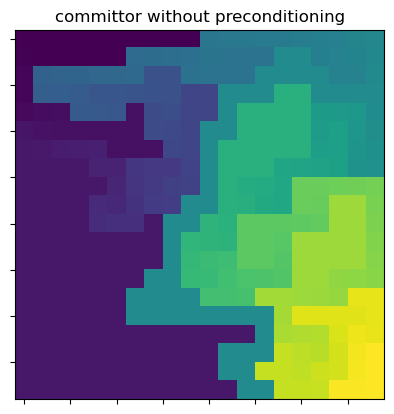

In [5]:
# visualize committor for CG w/o preconditioning

comm_wo = np.zeros(N)
comm_wo[0] = 0
comm_wo[-1] = 1
comm_wo[1:N-1] = (Dinv@x[k]).flatten()
comm_wo = comm_wo.reshape((sqrtN,sqrtN), order='F')

plt.imshow(comm_wo)
plt.title('committor without preconditioning')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.savefig('without preconditioning')
plt.show()

In [6]:
# CG w/ preconditioning

# preconditioner

ichol_fac = sp.linalg.cholesky(A.toarray(), lower=True)
M = ichol_fac@ichol_fac.T

# initialize

alpha = np.zeros(n,dtype=object)
x = np.zeros(n,dtype=object)
rw = np.zeros(n,dtype=object) # residual
rw_norm = np.zeros(n,dtype=object) # residual norm
y = np.zeros(n,dtype=object)
beta = np.zeros(n,dtype=object)
p = np.zeros(n,dtype=object)

x[0] = np.random.rand(n,1)
rw[0] = A@x[0] - b
rw_norm[0] = la.norm(rw[0])
y[0] = sp.linalg.solve(M, rw[0], assume_a='pos')
p[0] = -y[0]
k = 0
print('k = {}, |r| = {}'.format(k, rw_norm[k]))

# iterate while residual norm greater than tolerance

while rw_norm[k] >= tol:
    rkTyk = rw[k].T@y[k]
    Apk = A@p[k]
    alpha[k] = rkTyk / (p[k].T@Apk)
    x[k+1] = x[k] + alpha[k]*p[k]
    rw[k+1] = rw[k] + alpha[k]*Apk
    rw_norm[k+1] = la.norm(rw[k+1])
    y[k+1] = sp.linalg.solve(M, rw[k+1], assume_a='pos')
    beta[k+1] = (rw[k+1].T@y[k+1]) / rkTyk
    p[k+1] = -y[k+1] + beta[k+1]*p[k]
    k = k + 1
    print('k = {}, |r| = {}'.format(k, rw_norm[k]))

k = 0, |r| = 7.667369977431282
k = 1, |r| = 1.6872787688444408e-15


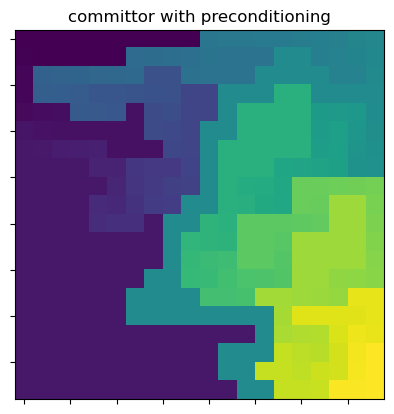

In [7]:
# visualize committor for CG w/ preconditioning

comm_w = np.zeros(N)
comm_w[0] = 0
comm_w[-1] = 1
comm_w[1:N-1] = (Dinv@x[k]).flatten()
comm_w = comm_w.reshape((sqrtN,sqrtN), order='F')

plt.imshow(comm_w)
plt.title('committor with preconditioning')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.savefig('with preconditioning')
plt.show()

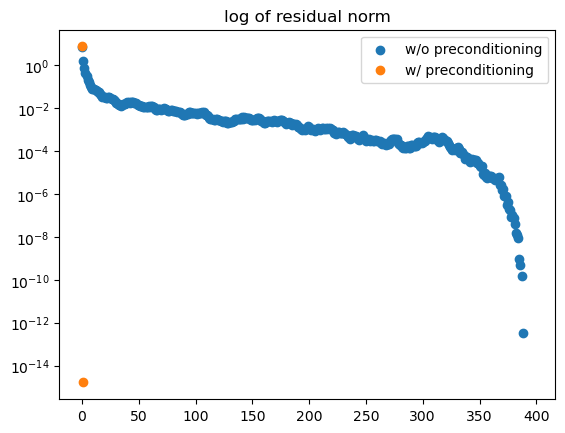

In [18]:
# plot residual norm of both algorithms

plt.scatter(range(n),rwo_norm)
plt.scatter(range(n),rw_norm)
plt.yscale('log')
plt.title('log of residual norm')
plt.legend(['w/o preconditioning','w/ preconditioning'])
plt.savefig('residual norm')
plt.show()